# MMI 701: Multimedia Signal Processing
## z-Transforms

In addition to last week's examples we will also use the module ```scipy.signal```so let us import the modules that we will use first

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sgn

### Region of convergence (ROC)
- The z-transform of a finite sequence (e.g. a discrete-time signal) can be represented as an array containing the coefficients of a polynomial in $z$ (and not $z^{-1}$)
- Convergence in this context will mean $\lim_{n\rightarrow{}\infty}|\sum_{n=-\infty}^{N}x(n)z^{-n}|<\infty$
- Let us first define a "sufficiently long" exponential signal and see where its  converges

<StemContainer object of 3 artists>

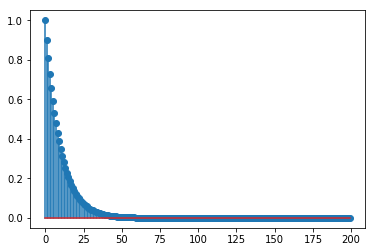

In [2]:
# We first define some of the functions that we will use

# An exponential signal generator
def exponentialsig(a, Nmax):
    ntime = np.arange(0, Nmax) # Define the sample indices that will be used
    sig = a**ntime # e.g. a**4 is the fourth power of a
    return sig, ntime

# Returns a complex exponential
def zval(r, theta): # 
    return r * np.exp(1j*theta) # note: 1j is the complex unit in Python

# A very ineffective implementation of the direct z-transform
def ztran(sig, ntime, zv):
    ztransform = np.sum(sig * zv ** (-ntime))
    return ztransform

# Let us try and see if we can generate the exponential signal
sig, ntime = exponentialsig(0.9, 200)
plt.stem(ntime, sig)
    

- Let us now compare whether this sequence converges to $(1-az^{-1})^{-1}$ when $z$ is in the ROC, i.e. when $|z|>|a|$.

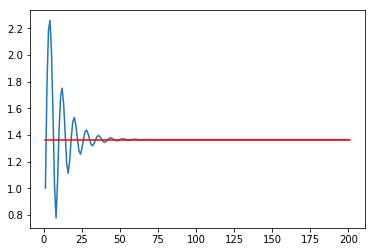

In [3]:
a = 0.9
zv = zval(1., np.pi/4)
convergence = 1/(1 - a/zv)
Nmax = 200
ztr = []

# We will now calculate the z-transform of the signal for increasing number of samples
for nmax in range(1, Nmax + 1):
    sig, ntime = exponentialsig(a, nmax)
    zt = ztran(sig, ntime, zv)
    ztr.append(zt)

# We will then plot and see than the result converges
zt = np.array(ztr, dtype=np.complex)
plt.plot(np.arange(1, Nmax + 1), np.abs(zt))
plt.plot([1, Nmax + 1], [np.abs(convergence), np.abs(convergence)], 'r')

- Good to see that the z-transform indeed converges for this selection of $r=1$ and $\theta=\pi/4$. How about $r=0.8$ and $\theta=\pi/4$, which is outside the ROC?

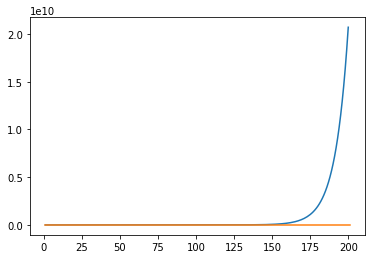

In [4]:
a = 0.9
zv = zval(.8, np.pi/4)
convergence = 1/(1 - a/zv)
Nmax = 200
ztr = []

for nmax in range(1, Nmax + 1):
    sig, ntime = exponentialsig(a, nmax)
    zt = ztran(sig, ntime, zv)
    ztr.append(zt)
    
zt = np.array(ztr, dtype=np.complex)
plt.plot(np.arange(1, Nmax + 1), np.abs(zt))
plt.plot([1, Nmax + 1], [np.abs(convergence), np.abs(convergence)])

- The z-transform diverges! Let us now randomly assign $r$ and $\theta$ to $z$ and try to show the ROC in a way similar to an ad-hoc Monte-Carlo simulation.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


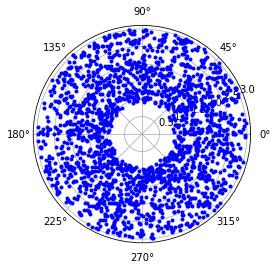

In [5]:
# Let us define the parameters first
a = 0.9
numsim = 3000
Rmax = 3
nmax = 200
rlist = [] # Empty list to populate with the z values for which we are in the ROC
thlist = [] # Empty list to populate with the z values for which we are in the ROC

# We will run ```numsim```simulations to fill-in the ROC
for ind in range(numsim):
    r = np.random.uniform(0, Rmax) # Generate a random value for the radius from a uniform distribution 
    theta = np.random.uniform(0, 2 * np.pi) # Generate a random value for the phase
    zv = zval(r, theta) # Generate a randomvalue for z the evaluate the z-transform
    threshold = np.abs(1/(1 - a/zv)) + 1e-10 # This is slightly above the value that the tansform converges to
    sig, ntime = exponentialsig(a, nmax) # Generate the signal
    zt = ztran(sig, ntime, zv) # Obtain the z-transform
    if np.abs(zt)<threshold: # If less than threshold keep the z-value
        rlist.append(r) 
        thlist.append(theta)
rlist = np.array(rlist)
tlist = np.array(thlist)

plt.polar(tlist, rlist, 'b.')

- Observe that radii above 0.9 result in a diverging z-transform
- It is not only the polar plot showing the ROC, but also Python itself complaining about ```overflow```that shows that the transform diverges.

### Stability and numerical precision

- We discussed during the lecture that for a causal discrete-time system to be stable its poles should be within the unit circle, i.e. $|z|=1$
- We will now try and see how we can analyse the stability of discrete-time systems

#### Representing polynomials as arrays

- The discrete-time systems that we will deal with have rational transfer functions of the form $H(z)=\frac{B(z)}{A(z)}$. 
- The numerator and denominator polynomials can be represented as numpy arrays
- Let us take the following system which we discussed in the lecture as an example:
$$H(z)=\frac{B(z)}{A(z)}=\frac{1-a^Mz^{-M}}{1-az^{-1}}=\frac{z^M-a^M}{z^{M-1}(z-a)}$$
- We know that this system has $M-1$ poles at the origin and $M-1$ zeros on a circle of radius $a$.

In [6]:
# Two utility functions to translate between Cartesian and Polar coordinates
def cart2pol(num):
    x = np.real(num)
    y = np.imag(num)
    r = np.sqrt(x**2+y**2)
    th = np.arctan2(y,x)
    return r, th

def pol2cart(r, theta):
    return r * (np.cos(theta) + 1j * np.sin(theta))

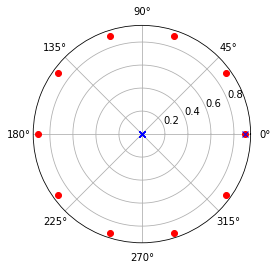

In [7]:
# Defining the system parameters
M = 10 # Order of the numerator
a = 0.9
Bz = np.zeros(M + 1) # Create an array containing zeros and then we will add non-zero coefficients 
Bz[0] = 1 # This is b_0
Bz[M] = -a**M # This is b_M and all the rest of the coefficients are zeroes
Az = np.zeros(M + 1) # Create an array containing zeros and then we will add non-zero coefficients
Az[0] = 1 # This is a_0
Az[1] = -a # This is a_1 and all the rest of the coefficients are zeroes

# Obtain the zeros and poles via root-finding
zeros = np.roots(Bz)
poles = np.roots(Az)

# Create empty lists to populate with zeroes and poles
rzeros = []
tzeros = []

rpoles = []
tpoles = []

for item in zeros: # For all zeroes in the list
    r, th = cart2pol(item) # Convert to polar form
    rzeros.append(r)
    tzeros.append(th)
    
for item in poles: # For all zeroes in the list
    r, th = cart2pol(item)
    rpoles.append(r)
    tpoles.append(th)
    
plt.polar(tzeros, rzeros, 'ro')
plt.polar(tpoles, rpoles, 'bx')

- As expected the poles are inside the unit circle and the causal system is stable
- Numerical precision is not a big worry away from the unit circle. However, as roots get close to the unit circle, the numerical precision dictates whether or not the stability analysis is correct

The radii of the zeros of the system are: [1.0000000000000009, 0.9999999999999999, 0.9999999999999999, 0.999999999999999, 0.999999999999999, 1.0000000000000007, 1.0000000000000007, 0.9999999999999998, 1.0000000000000007, 1.0000000000000007]
The radii of the poles of the system are: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


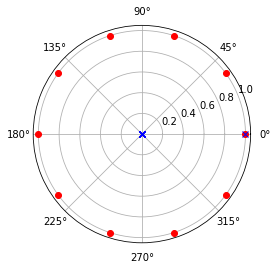

In [8]:
M = 10
a = 0.99999999999999999
Bz = np.zeros(M + 1)
Bz[0] = 1
Bz[M] = -a**M
Az = np.zeros(M + 1)
Az[0] = 1
Az[1] = -a

zeros = np.roots(Bz)
poles = np.roots(Az)

rzeros = []
tzeros = []

rpoles = []
tpoles = []

for item in zeros:
    r, th = cart2pol(item)
    rzeros.append(r)
    tzeros.append(th)
    
for item in poles:
    r, th = cart2pol(item)
    rpoles.append(r)
    tpoles.append(th)

plt.polar(tzeros, rzeros, 'ro')
plt.polar(tpoles, rpoles, 'bx')

# Let us see the radii of the zeroes and poles
print("The radii of the zeros of the system are: " + str(rzeros))
print("The radii of the poles of the system are: " + str(rpoles))

- Now you see that the radius of the single pole not at the origin is exactly 1.0, instead of 0.99999999999999999 meaning that our system is critically stable according to this analysis, despite our system being actually stable.
- Also, the radii of the zeros are:
    1. Not complex conjugates of each other as would be expected from complex roots, and...
    2. Outside the unit circle!
- All this despite the emulated 64-bit double precision arithmetic afforded by Python. Matlab also is not different.
- **Moral of the story: DO NOT TRUST FINITE PRECISION ARITHMETIC FOR STABILITY ANALYSIS OF REAL SYSTEMS!**

### Response of system and its roots
- Impulse response of an LTI systems strongly depends on the roots of its transfer function.
- Let us see how that response changes in response to the change in single pair of poles as we move the poles closer to the unit circle.
- The system that we will emulate is: $$H(z)=\frac{1}{(z-p)(z-p^*)}$$
- We will try 5 different pole radii $|p|=0.5, 0.8, 0.97, 0.99, 1.01$

<StemContainer object of 3 artists>

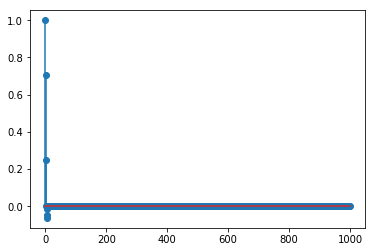

In [19]:
impulse = np.zeros(1000) # Create an zeroes array
impulse[0] = 1. # The first element is 1 to simulate an impulse

# We will try this with three 

B = np.array([1.]) # The numerator polynomial
p1 = pol2cart(0.5, np.pi/4) # Let the filter have a single pair of complex conjugate  poles
p2 = np.conjugate(p1)
A = np.poly([p1, p2]) # Convert to a polynomial to obtain the denominator coefficients

h = sgn.lfilter(B, A, impulse) # This is the generic filtering function in scipy.signal

plt.stem(h)

<StemContainer object of 3 artists>

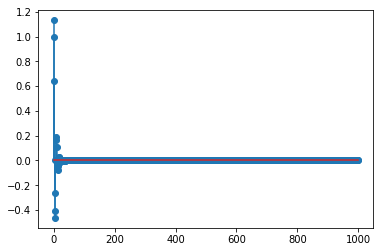

In [15]:
p1 = pol2cart(0.8, np.pi/4)
p2 = np.conjugate(p1)
A = np.poly([p1, p2])

h = sgn.lfilter(B, A, impulse)

plt.stem(h)

<StemContainer object of 3 artists>

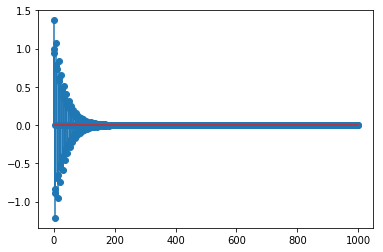

In [16]:
B = np.array([1.])
p1 = pol2cart(0.97, np.pi/4)
p2 = np.conjugate(p1)
A = np.poly([p1, p2])

h = sgn.lfilter(B, A, impulse)

plt.stem(h)

<StemContainer object of 3 artists>

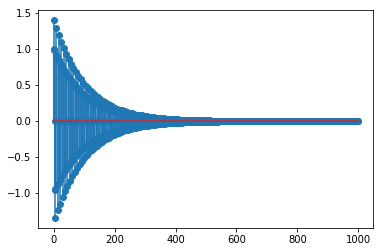

In [17]:
B = np.array([1.])
p1 = pol2cart(0.99, np.pi/4)
p2 = np.conjugate(p1)
A = np.poly([p1, p2])

h = sgn.lfilter(B, A, impulse)

plt.stem(h)

<StemContainer object of 3 artists>

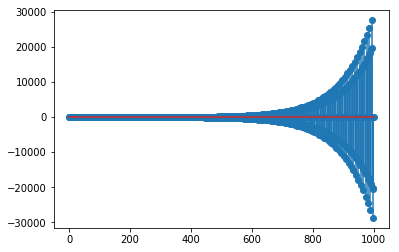

In [18]:
# This will diverge
B = np.array([1.])
p1 = pol2cart(1.01, np.pi/4)
p2 = np.conjugate(p1)
A = np.poly([p1, p2])

h = sgn.lfilter(B, A, impulse)

plt.stem(h)

#### © 2020, Huseyin Hacihabiboglu, (hhuseyin@metu.edu.tr), METU Graduate School of Informatics